In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train/255
X_test = X_test/255

In [6]:
img_width,img_height,num_chanels = 28,28,1

In [7]:
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(10000,28,28,1)
input_shape = (img_height,img_width,num_chanels)

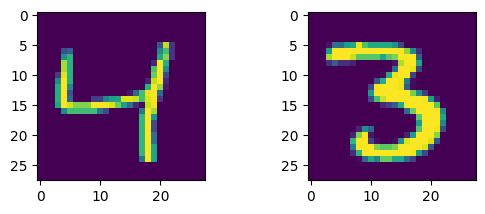

In [8]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[2])
plt.subplot(222)
plt.imshow(X_train[12])
plt.show()

In [9]:
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [10]:
latent_space = 2
input_layer = layers.Input(shape = (28,28,1),name = "input-to-encoder")
x = layers.Conv2D(32,6,padding = "same",activation = "relu")(input_layer)
x = layers.Conv2D(64,6,padding = "same",activation = "relu",strides=(2,2))(x)
x = layers.Conv2D(64,6,padding = "same",activation = "relu")(x)
x = layers.Conv2D(64,6,padding = "same",activation = "relu")(x)

In [11]:
conv_shape = K.int_shape(x)
print(conv_shape)

(None, 14, 14, 64)


In [12]:
x = layers.Flatten()(x)
print(x.shape)
x = layers.Dense(32,activation = "relu")(x)
print(x.shape)

(None, 12544)
(None, 32)


In [13]:
z_mu = layers.Dense(latent_space,name="latent_zmu")(x)
z_sigma = layers.Dense(latent_space,name = "latent_sigma")(x)

In [14]:
#reparametraizartion trick:
def sample_z(args):
    z_mu,z_sigma = args
    eps = K.random_normal(shape = (K.shape(z_mu)[0],K.int_shape(z_mu)[1]))
    return z_mu + K.exp(z_sigma/2)*eps

In [15]:
z = layers.Lambda(sample_z,output_shape=(latent_space,),name='z')([z_mu,z_sigma])

In [16]:
encoder = tf.keras.Model(inputs = input_layer,outputs =[z_mu,z_sigma,z],name = "encoder")

In [17]:
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input-to-encoder (InputLayer)  [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   1184        ['input-to-encoder[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   73792       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   147520      ['conv2d_1[0][0]']               
                                                                                            

In [18]:
decoder_input = layers.Input(shape=(latent_space,),name="decoder_input")
x = layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3],activation = "relu")(decoder_input)
x = layers.Reshape((conv_shape[1],conv_shape[2],conv_shape[3]))(x)
x = layers.Conv2DTranspose(32,3,padding='same',activation = "relu",strides=(2,2))(x)
x = layers.Conv2DTranspose(1,3,padding="same",activation="sigmoid",name='deocder')(x)

decoder = tf.keras.Model(decoder_input,x,name="decoder")

In [19]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 12544)             37632     
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 32)       18464     
 nspose)                                                         
                                                                 
 deocder (Conv2DTranspose)   (None, 28, 28, 1)         289       
                                                                 
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_______________________________________________________

In [20]:
z_decoded = decoder(z)

In [21]:
class CustomLayer(tf.keras.layers.Layer):
    def vae_loss(self,x,z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        recon_loss = tf.keras.metrics.binary_crossentropy(x,z_decoded)
        kl_loss = -5e-4*K.mean(1+z_sigma-K.square(z_mu)-K.exp(z_sigma),axis=-1)
        return K.mean(recon_loss+kl_loss)
    def call(self,inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x,z_decoded)
        self.add_loss(loss,inputs=inputs)
        return x

In [22]:
y = CustomLayer()([input_layer,z_decoded])

In [23]:
vae = tf.keras.Model(input_layer,y,name='vae')

In [24]:
vae.compile(optimizer="adam",loss=None)

In [25]:
print(vae.summary())

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input-to-encoder (InputLayer)  [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   1184        ['input-to-encoder[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   73792       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   147520      ['conv2d_1[0][0]']               
                                                                                                

In [27]:
vae.fit(X_train,None,epochs=15,batch_size=32,validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/15
48000/48000 [==============================] - 12s 248us/sample - loss: 0.1922 - val_loss: 0.1906
Epoch 2/15
48000/48000 [==============================] - 12s 244us/sample - loss: 0.1892 - val_loss: 0.1882
Epoch 3/15
48000/48000 [==============================] - 12s 242us/sample - loss: 0.1872 - val_loss: 0.1889
Epoch 4/15
48000/48000 [==============================] - 12s 244us/sample - loss: 0.1858 - val_loss: 0.1853
Epoch 5/15
48000/48000 [==============================] - 13s 261us/sample - loss: 0.1849 - val_loss: 0.1846
Epoch 6/15
48000/48000 [==============================] - 12s 244us/sample - loss: 0.1837 - val_loss: 0.1831
Epoch 7/15
48000/48000 [==============================] - 12s 244us/sample - loss: 0.1830 - val_loss: 0.1822
Epoch 8/15
48000/48000 [==============================] - 12s 243us/sample - loss: 0.1821 - val_loss: 0.1838
Epoch 9/15
48000/48000 [==============================] - 12s 244us/sample - l

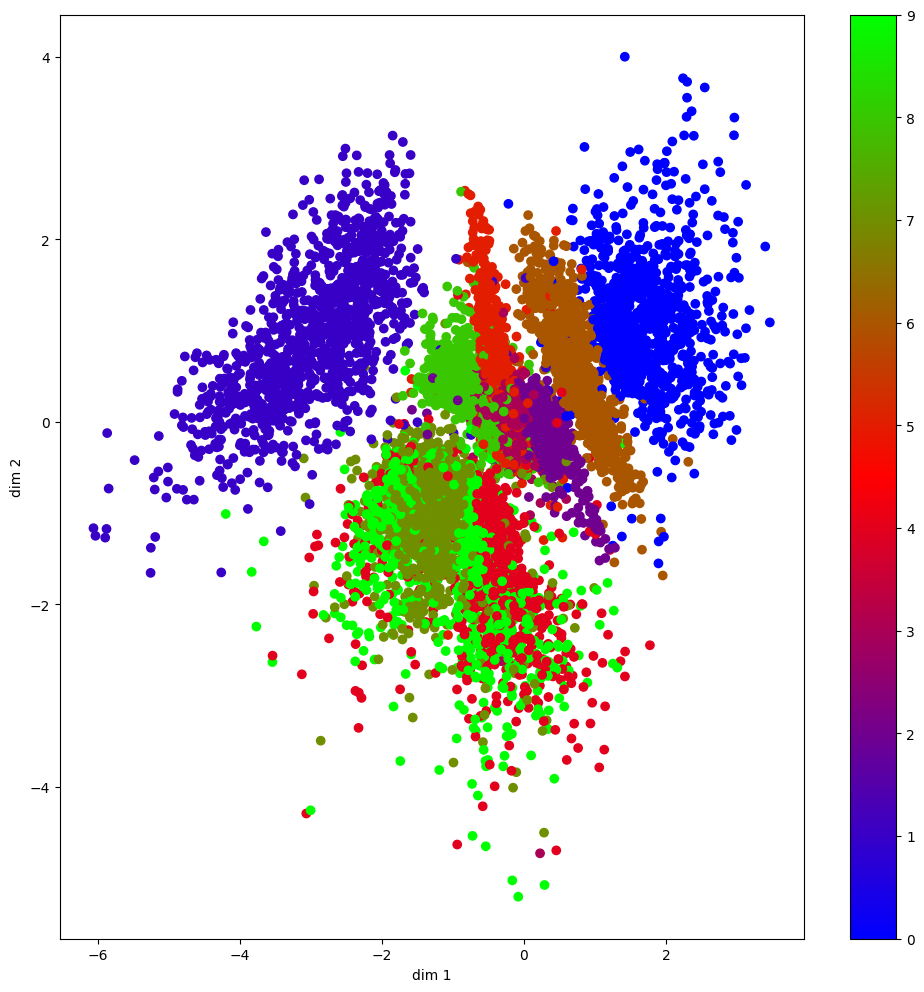

In [30]:
#lets visualize latent space:
mu,_,_ = encoder.predict(X_test)
plt.figure(figsize=(12,12))
plt.scatter( mu[:,0] ,mu[:,1],c=y_test,cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

In [92]:
print(mu.shape)
print(mu)


(10000, 2)
[[-1.3553597  -1.0333893 ]
 [ 0.2649781  -0.30652368]
 [-3.3849444   1.5021936 ]
 ...
 [-0.6673583  -0.8950045 ]
 [-0.6075126   1.4286156 ]
 [ 0.867873    0.8982254 ]]


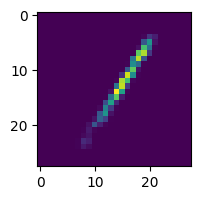

In [84]:
# lets generate some mnist numbers:
sample_vector = np.array([[-4,4]])
decoded_example = decoder.predict(sample_vector)
decoded_example = decoded_example.reshape(28,28)
plt.figure(figsize=(2,2))
plt.imshow(decoded_example)

In [89]:
#we will use figure instead
figure = np.zeros((28*20,28*20,1))
grid_x = np.linspace(-5,5,20)
grig_y = np.linspace(-5,5,20)[::-1]
for i,yi in enumerate(grig_y):
  for j,xi in enumerate(grid_x):
    sample_vector = np.array([[xi,yi]])
    decoded_example = decoder.predict(sample_vector)[0].reshape(28,28,1)
    figure[i*28:(i+1)*28,j*28:(j+1)*28] = decoded_example

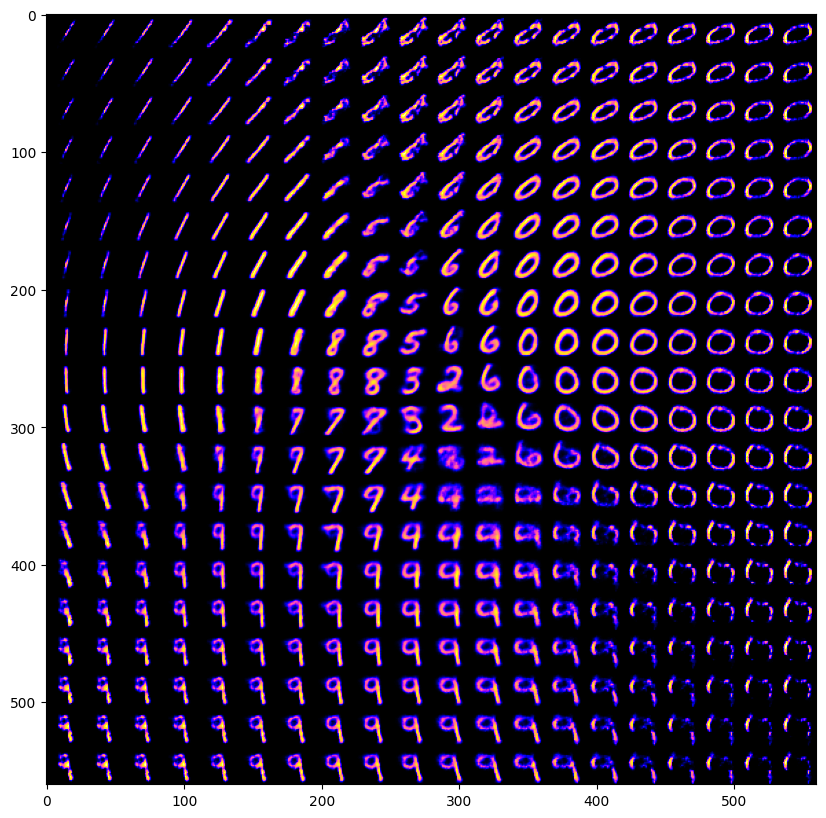

In [90]:
plt.figure(figsize=(10, 10))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()  